In [1]:
import os, sys
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from copy import copy

Matplotlib created a temporary config/cache directory at /tmp/jobs/26091636/matplotlib-ni11sgw9 because the default path (/dali/lgrandi/xenonnt/software/nton/mplconfigs) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Plotter function

In [2]:
def get_eq_energy(en, g1, g2, W):
    cs1_max = en/W*g1
    cs1_ = np.linspace(0, cs1_max, 501)
    cs2_ = g2*(en/W - cs1_/g1)
    return (cs1_, cs2_)
def make_cs1_cs2_fig(ens = [2.0, 5.0,10.0, 15.0], 
                     yrange=(200,3e4),
                     xrange=(0,150), 
                     figsize=(10,8),
                     g1=0.1423,
                     g2=43.515,
                     W =0.01344,
                     with_cax=True
                     ):
    fig = plt.figure(figsize=figsize, facecolor="w")
    ax_rect = [0.08,0.08, 0.9,0.9]
    if with_cax:
        ax_rect = [0.08,0.08, 0.8,0.9]
    cax_rect = [ax_rect[0]+ax_rect[2]+0.01,
                ax_rect[1],
                0.04, 
                ax_rect[3]]
    ax=fig.add_axes(ax_rect)
    ax.set_yscale("log")
    for en in ens:
        l_ = get_eq_energy(en,g1=g1, g2=g2,W=W)
        plt.plot(l_[0],l_[1], c="0.5", ls ="--")
        if l_[0][-1]<xrange[1]:
            plt.text(l_[0][-1]+1.0, yrange[0]*1.03, "{:0.1f} keVee".format(en),fontsize=13, rotation=270,
                 va="bottom", ha="center", color="0.05")
    plt.xlabel("cS1 area [ PE ]", fontsize=14)
    plt.ylabel("cS2 area [ PE ]", fontsize=14)
    plt.ylim(yrange[0], yrange[1])
    plt.xlim(xrange[0], xrange[1])
    if not with_cax: return fig, ax
    cax = fig.add_axes(cax_rect)
    return fig, ax ,cax

### Checking files 

In [3]:
files_ = glob.glob("*.npz")
files_.sort()
all_templates = [fname.split(".npz")[0] for fname in files_]
all_templates

['Kr85',
 'Pb212',
 'Pb214',
 'SolarNu',
 'Xe136_2vbb',
 'cevns_8b',
 'cevns_DSNB',
 'cevns_atm',
 'cevns_hep',
 'wimp_1000GeV',
 'wimp_100GeV',
 'wimp_10GeV',
 'wimp_200GeV',
 'wimp_20GeV',
 'wimp_50GeV',
 'wimp_6GeV']

In [4]:
#component ='SolarNu'
component ='Pb212'
template_data = np.load(component+".npz")

cS1_bins = template_data['cS1_bins']
cS2_bins = template_data['cS2_bins']
template = template_data['template']
infoline = template_data['info']

In [5]:
cmap = None
if 'cevns' in component:
    cmap = copy(cm.Greens)
elif 'wimp' in component:
    cmap = copy(cm.Blues)
else:
    cmap = copy(cm.Reds)
cmap.set_under("w")

Text(0, 0.5, 'Rate [ ev / (t y keV )]')

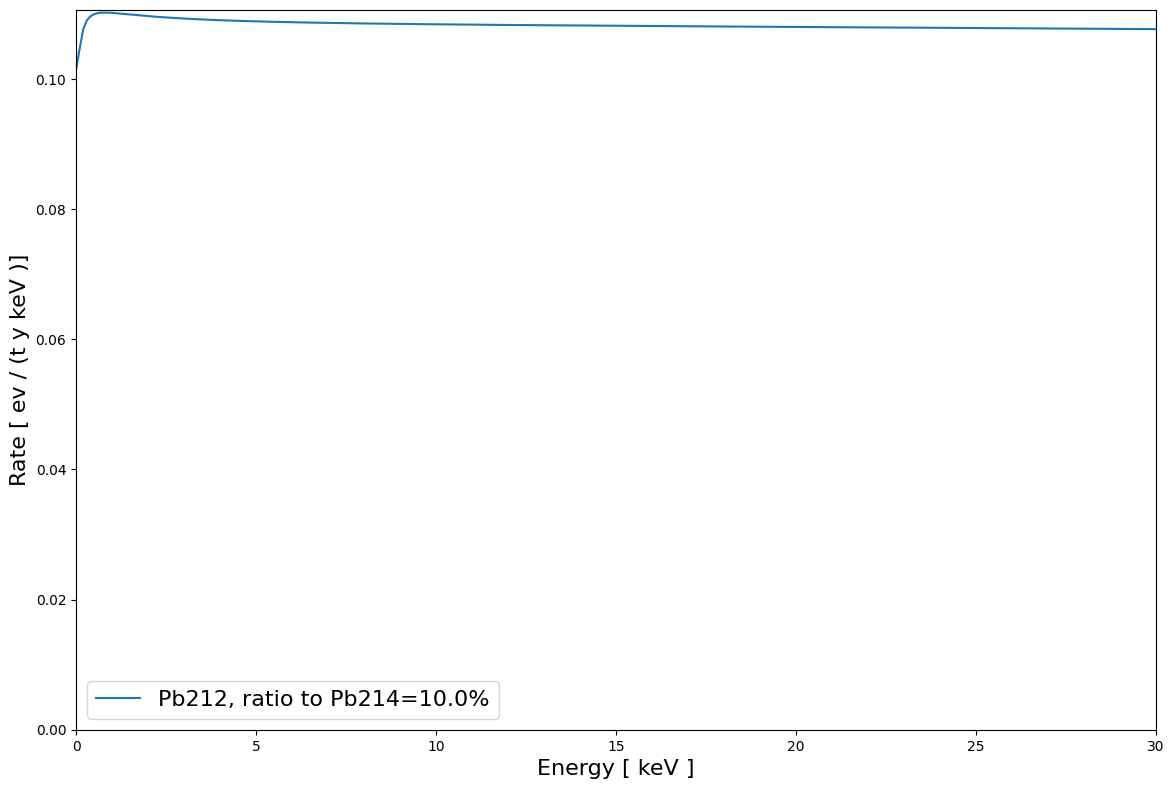

In [6]:
fig=plt.figure(figsize=(12,8))
ax=fig.add_axes([0.08,0.08,0.9,0.9])
ax.plot(template_data['rate_ens'], template_data['rate_values'], label=infoline)
ax.legend(fontsize=16)
ax.set_xlim(template_data['rate_ens'][0],template_data['rate_ens'][-1])
ax.set_ylim(0.0)
ax.set_xlabel("Energy [ keV ]",fontsize=16)
ax.set_ylabel("Rate [ ev / (t y keV )]",fontsize=16)

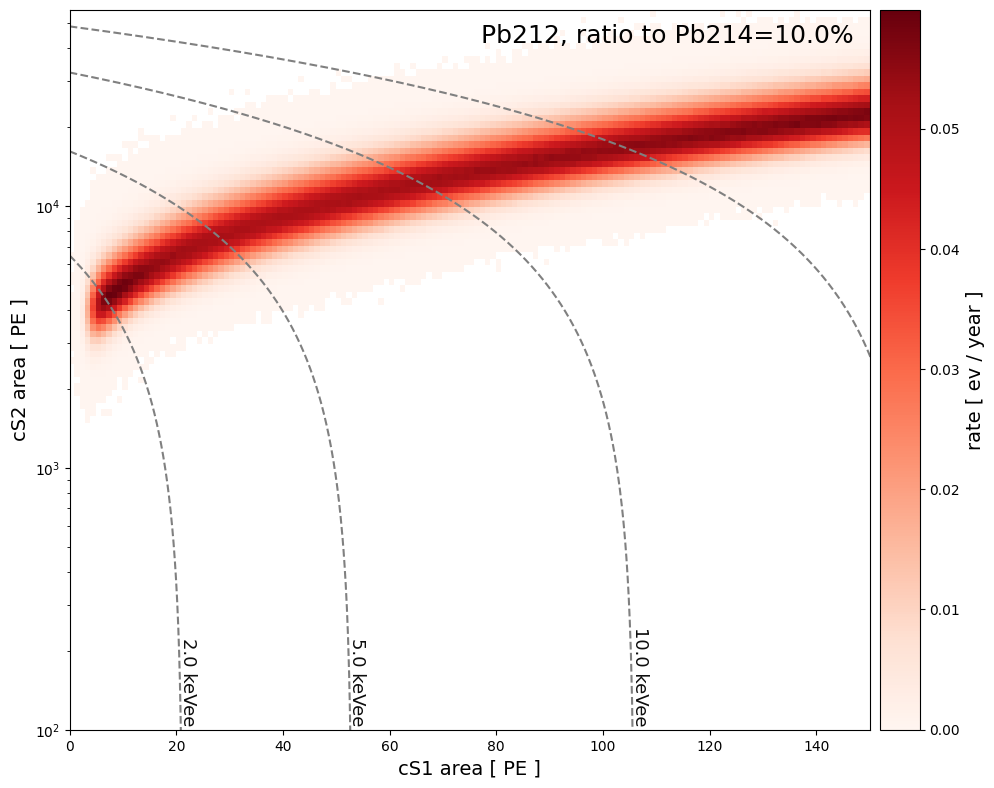

In [7]:
fig,ax,cax = make_cs1_cs2_fig(
                            g1 = 1.* template_data['g1'],
                            g2 = 1.* template_data['g2'],
                            W = 1.* template_data['W'],
                            yrange=(cS2_bins[0],cS2_bins[-1])
                            )
c=ax.pcolor(cS1_bins, cS2_bins, template.T, cmap=cmap, vmin=1e-20)
ax.text(0.98, 0.98,  infoline, transform=ax.transAxes, va="top", ha="right", fontsize=18)
cbar=plt.colorbar(c, cax=cax)
cbar.set_label("rate [ ev / year ]", fontsize=14)

### Conversion of Provided Templates for Binference

In [9]:
from datetime import datetime
import h5py

In [18]:
### Function to convert histogrm to template format expected by binference.

def numpy_to_template(bins, histograms, file_name, histogram_names=None, axis_names=None, metadata={"version":"0.0","date":datetime.now().strftime('%Y%m%d_%H:%M:%S')}):

    if histogram_names is None:
        histogram_names = ["{:d}".format(i) for i in range(len(histograms))]
    with h5py.File(file_name, "w") as f:
        print("file f opened, 1st time, ",list(f.keys()))
        for k, i in metadata.items():
            f.attrs[k] = i
        if axis_names is None:
            axis_names = ["" for i in range(len(bins))]
        for i, (b, bn) in enumerate(zip(bins, axis_names)):
            dset = f.create_dataset("bins/{:d}".format(i), data=b)
            dset.attrs["name"] = bn
        for histogram, histogram_name in zip(histograms, histogram_names):
            print("writing histogram name",histogram_name)
            dset = f.create_dataset("./templates/{:s}".format(histogram_name), data=histogram)

In [14]:
### Hardcoded FV. Update to take FV from templates

fiducial_volume=31.5

### Load and Combine ER Templates

In [15]:
#component ='SolarNu'
component ='Kr85'
template_data = np.load(component+".npz")

cS1_bins = template_data['cS1_bins']
cS2_bins = template_data['cS2_bins']
infoline = template_data['info']


template_kr = template_data['template']
print(np.sum(template_kr))

component ='Pb212'
template_data = np.load(component+".npz")
template_pb212 = template_data['template']
print(np.sum(template_pb212))

component ='Pb214'
template_data = np.load(component+".npz")
template_pb214 = template_data['template']
print(np.sum(template_pb214))

component ='SolarNu'
template_data = np.load(component+".npz")
template_solarnu = template_data['template']
print(np.sum(template_solarnu))

component ='Xe136_2vbb'
template_data = np.load(component+".npz")
template_xe136 = template_data['template']
print(np.sum(template_xe136))

template_er = template_pb212 +template_pb214 + template_xe136 + template_kr

13.88858866397573
67.44419924462895
287.8062285021164
1544.9219870842703
1271.664097404609


#### Check and Save SolarNu Template

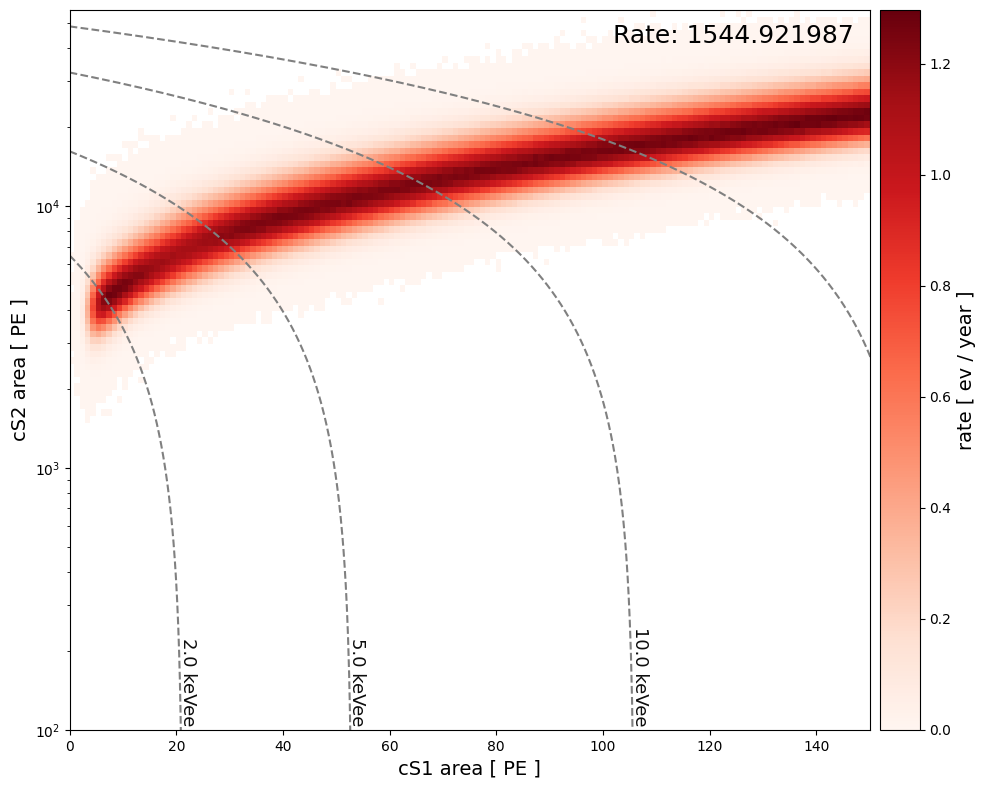

In [16]:
fig,ax,cax = make_cs1_cs2_fig(
                            g1 = 1.* template_data['g1'],
                            g2 = 1.* template_data['g2'],
                            W = 1.* template_data['W'],
                            yrange=(cS2_bins[0],cS2_bins[-1])
                            )
c=ax.pcolor(cS1_bins, cS2_bins, template_solarnu.T, cmap=cmap, vmin=1e-20)
ax.text(0.98, 0.98,  'Rate: %f' %(np.sum(template_solarnu)), transform=ax.transAxes, va="top", ha="right", fontsize=18)
cbar=plt.colorbar(c, cax=cax)
cbar.set_label("rate [ ev / year ]", fontsize=14)

In [17]:
### Saving the provided Darin template to fromat expected by binference.
test_conv = numpy_to_template([cS1_bins, np.log10(cS2_bins)], [template_solarnu/fiducial_volume], 'Solar_Nu_DarwinTemplate.hdf', 
                              histogram_names = ['hmc'], axis_names = ['cS1', 'cS2'])

file f opened, 1st time,  []
writing histogram name hmc


#### Check and Save ER Template

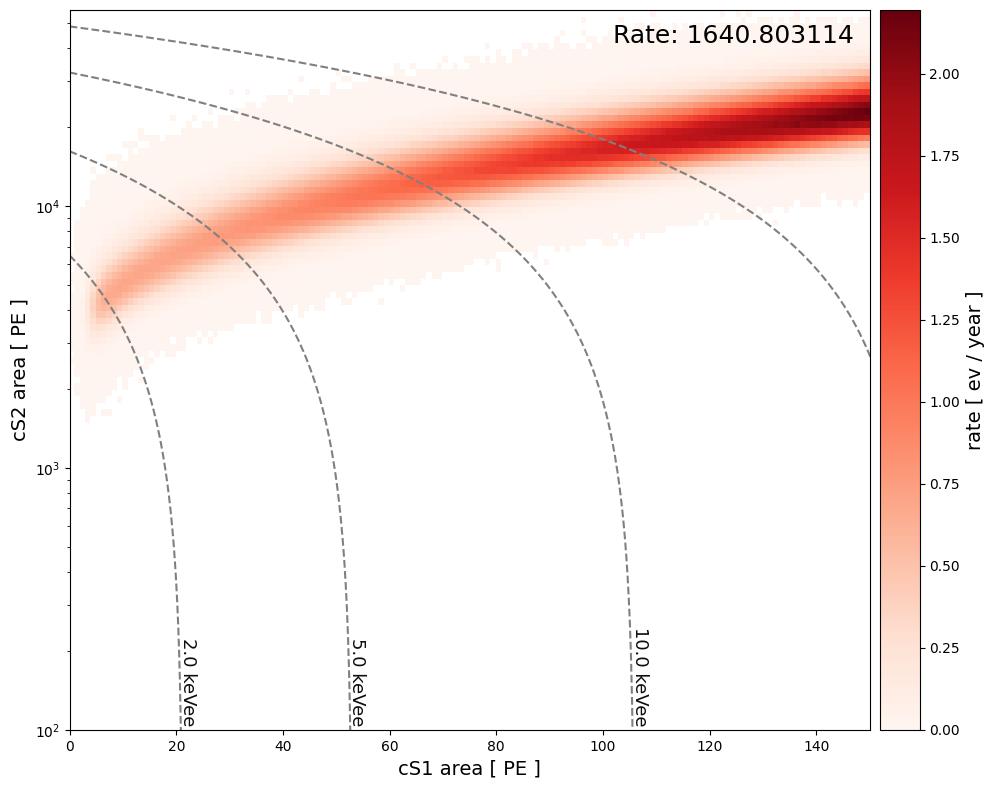

In [11]:
fig,ax,cax = make_cs1_cs2_fig(
                            g1 = 1.* template_data['g1'],
                            g2 = 1.* template_data['g2'],
                            W = 1.* template_data['W'],
                            yrange=(cS2_bins[0],cS2_bins[-1])
                            )
c=ax.pcolor(cS1_bins, cS2_bins, template_er.T, cmap=cmap, vmin=1e-20)
ax.text(0.98, 0.98,  'Rate: %f' %(np.sum(template_er)), transform=ax.transAxes, va="top", ha="right", fontsize=18)
cbar=plt.colorbar(c, cax=cax)
cbar.set_label("rate [ ev / year ]", fontsize=14)

In [13]:
test_conv = numpy_to_template([cS1_bins, np.log10(cS2_bins)], [template_er/fiducial_volume], 'ER_DarwinTemplate.hdf', 
                              histogram_names = ['hmc'], axis_names = ['cS1', 'cS2'])

file f opened, 1st time,  []
writing histogram name hmc


### Solar Neutrino Backgrounds

In [17]:
#component ='SolarNu'
component ='cevns_8b'
template_data = np.load(component+".npz")

cS1_bins = template_data['cS1_bins']
cS2_bins = template_data['cS2_bins']
infoline = template_data['info']


template_cevns_8b = template_data['template']
print(np.sum(template_cevns_8b))

component ='cevns_hep'
template_data = np.load(component+".npz")
template_cevns_hep = template_data['template']
print(np.sum(template_cevns_hep))


template_solar_cevns = template_cevns_hep + template_cevns_8b

21.12326193803925
0.7140229625374702


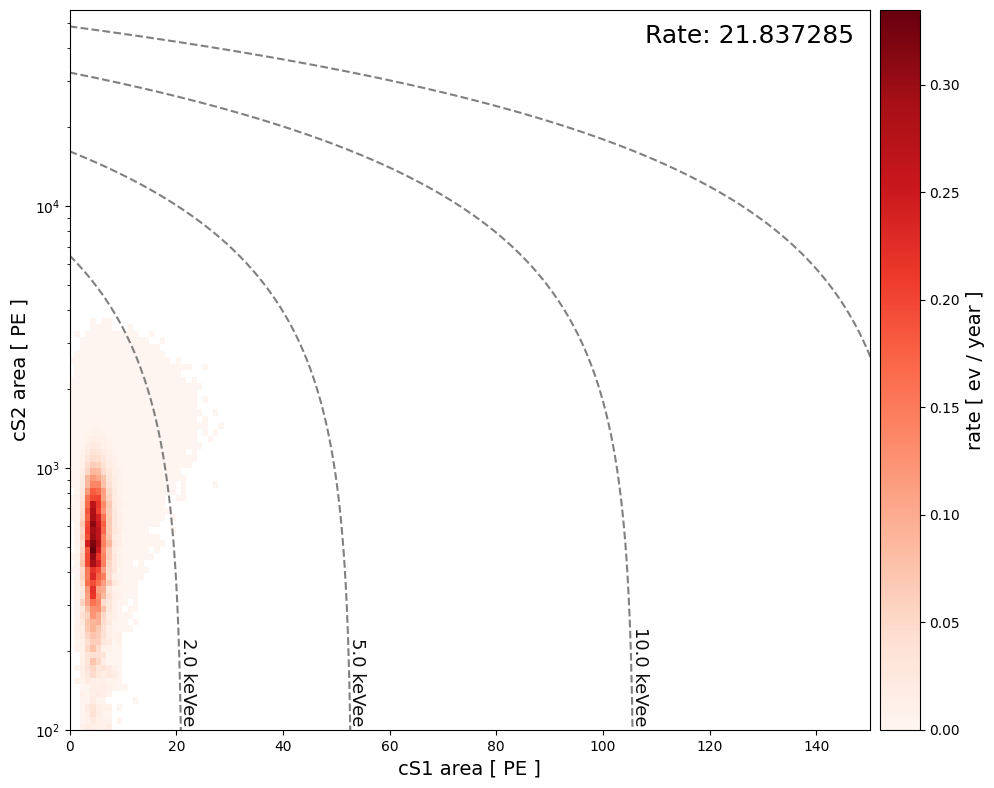

In [18]:
fig,ax,cax = make_cs1_cs2_fig(
                            g1 = 1.* template_data['g1'],
                            g2 = 1.* template_data['g2'],
                            W = 1.* template_data['W'],
                            yrange=(cS2_bins[0],cS2_bins[-1])
                            )
c=ax.pcolor(cS1_bins, cS2_bins, template_solar_cevns.T, cmap=cmap, vmin=1e-20)
ax.text(0.98, 0.98,  'Rate: %f' %(np.sum(template_solar_cevns)), transform=ax.transAxes, va="top", ha="right", fontsize=18)
cbar=plt.colorbar(c, cax=cax)
cbar.set_label("rate [ ev / year ]", fontsize=14)

In [55]:
test_conv = numpy_to_template([cS1_bins, np.log10(cS2_bins)], [template_solar_cevns/fiducial_volume], 'CEvNS_Solar_DarwinTemplate.hdf', 
                              histogram_names = ['hmc'], axis_names = ['cS1', 'cS2'])

file f opened, 1st time,  []
writing histogram name hmc


### DSNB Neutrino Backgrounds

In [60]:
component ='cevns_atm'
template_data = np.load(component+".npz")

cS1_bins = template_data['cS1_bins']
cS2_bins = template_data['cS2_bins']
infoline = template_data['info']


template_cevns_atm = template_data['template']
print(np.sum(template_cevns_atm))

component ='cevns_DSNB'
template_data = np.load(component+".npz")
template_cevns_DSNB = template_data['template']
print(np.sum(template_cevns_DSNB))


template_dsnb_cevns = template_cevns_atm + template_cevns_DSNB

1.3109522860775669
0.06760064179312082


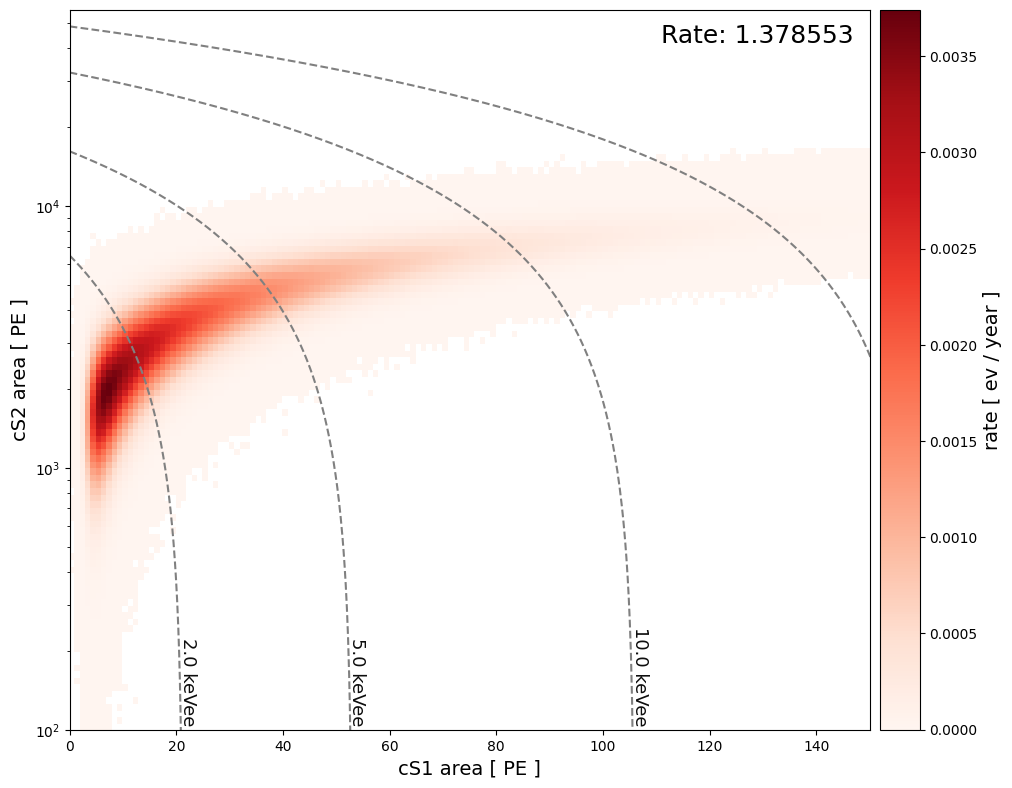

In [64]:
fig,ax,cax = make_cs1_cs2_fig(
                            g1 = 1.* template_data['g1'],
                            g2 = 1.* template_data['g2'],
                            W = 1.* template_data['W'],
                            yrange=(cS2_bins[0],cS2_bins[-1])
                            )
c=ax.pcolor(cS1_bins, cS2_bins, template_dsnb_cevns.T, cmap=cmap, vmin=1e-20)
ax.text(0.98, 0.98,  'Rate: %f' %(np.sum(template_dsnb_cevns)), transform=ax.transAxes, va="top", ha="right", fontsize=18)
cbar=plt.colorbar(c, cax=cax)
cbar.set_label("rate [ ev / year ]", fontsize=14)

In [66]:
test_conv = numpy_to_template([cS1_bins, np.log10(cS2_bins)], [template_dsnb_cevns/fiducial_volume], 'CEvNS_ATM_DarwinTemplate.hdf', 
                              histogram_names = ['hmc'], axis_names = ['cS1', 'cS2'])

file f opened, 1st time,  []
writing histogram name hmc


### WIMP Templates

In [63]:
component ='wimp_100GeV'
template_data = np.load(component+".npz")

cS1_bins = template_data['cS1_bins']
cS2_bins = template_data['cS2_bins']
infoline = template_data['info']


template_wimp = template_data['template']
print(np.sum(template_wimp))

5227.320850372652


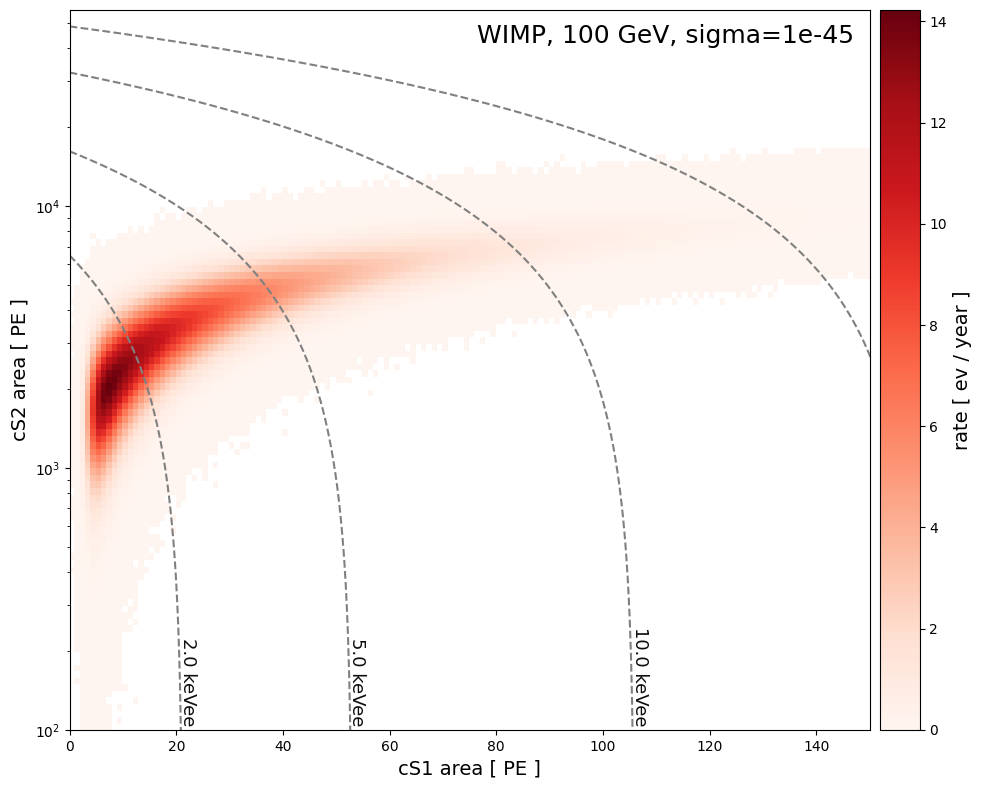

In [64]:
fig,ax,cax = make_cs1_cs2_fig(
                            g1 = 1.* template_data['g1'],
                            g2 = 1.* template_data['g2'],
                            W = 1.* template_data['W'],
                            yrange=(cS2_bins[0],cS2_bins[-1])
                            )
c=ax.pcolor(cS1_bins, cS2_bins, template_wimp.T, cmap=cmap, vmin=1e-20)
ax.text(0.98, 0.98,  infoline, transform=ax.transAxes, va="top", ha="right", fontsize=18)
cbar=plt.colorbar(c, cax=cax)
cbar.set_label("rate [ ev / year ]", fontsize=14)

In [54]:
test_conv = numpy_to_template([cS1_bins, np.log10(cS2_bins)], [template_wimp/fiducial_volume/1000], "WIMP_100GeV_DarwinTemplate.hdf", 
                              histogram_names = ['hmc'], axis_names = ['cS1', 'cS2'])

file f opened, 1st time,  []
writing histogram name hmc
